In [1]:
import torchvision
import torch

from matplotlib.pyplot import *
%matplotlib widget

import numpy as np

import torchvision.datasets as datasets

In [2]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

# Allocate images and labels onto numpy arrays

In [3]:
targets = np.zeros(len(mnist_trainset))
imgs = np.zeros((len(mnist_trainset), 28,28))

for _i in range(len(mnist_trainset)):
    targets[_i] = mnist_trainset[_i][1]
    imgs[_i] = mnist_trainset[_i][0]    

In [4]:
test_targets = np.zeros(len(mnist_testset))
test_imgs = np.zeros((len(mnist_testset), 28,28))

for _i in range(len(mnist_testset)):
    test_targets[_i] = mnist_testset[_i][1]
    test_imgs[_i] = mnist_testset[_i][0]

# Separate test numbers

In [11]:
def GetNumbers(imgs, targets):
    for _n in range(9):
        _imgs_n = imgs[np.where(test_targets==_n)[0]]
        
        if _n==0:
            numbers = np.zeros((1, *_imgs_n.shape))
            numbers[0] = _imgs_n
            
        max_n = np.min((_imgs_n.shape[0], numbers.shape[1]))
        
        if _n != 0:
            numbers = np.concatenate([numbers[:, :max_n], [_imgs_n[:max_n]]], axis=0)
                
    return numbers

number_imgs = GetNumbers(test_imgs, test_targets)

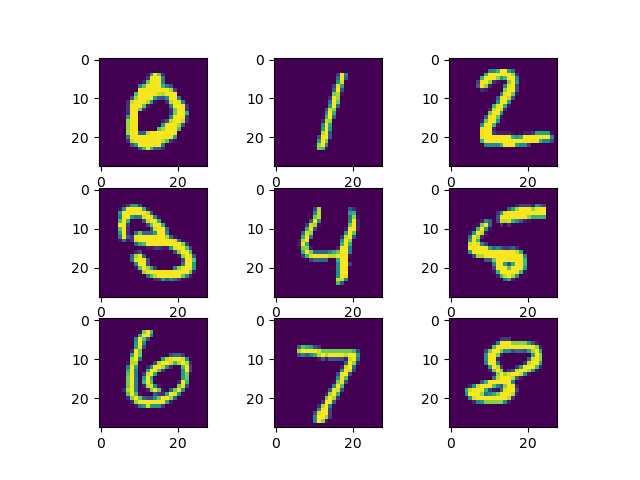

In [12]:
fig, axs = subplots(3,3)
for _i in range(3):
    axs[0,_i].imshow(number_imgs[_i, 0])
    axs[1,_i].imshow(number_imgs[3+_i, 0])
    axs[2,_i].imshow(number_imgs[6+_i, 0])

# Construct Input Imgs with one element from each number

In [16]:
def PlaceSquare(number, indice, canvas):
    canvas[indice[0]*28:(indice[0]+1)*28, indice[1]*28:(indice[1]+1)*28] = number
    return canvas

def PlotImg(number_set, number):
    canvas = np.zeros((28*3, 28*3))

    combinations = [(0,0),(0,1),(0,2),
                 (1,0),(1,1),(1,2),
                 (2,0),(2,1),(2,2)]

    _number = np.random.choice(np.arange(9), 1)[0]
    number_place = combinations[_number]
    
    canvas = PlaceSquare(number_set[number], number_place, canvas)
        
    combinations.remove(number_place)

    confusion_numbers = np.concatenate([np.arange(9)[:number], np.arange(9)[number+1:]], axis=0)
    
    np.random.shuffle(confusion_numbers)

    for _s in range(len(confusion_numbers)):
        canvas = PlaceSquare(number_set[confusion_numbers[_s]], combinations[_s], canvas)

    label = np.zeros((3,3))
    label[number_place[0], number_place[1]] = 1.

    return canvas, label

target_number = 0

canvas, label = PlotImg(number_imgs[:,0], 1)

input_imgs = np.zeros((number_imgs.shape[1], 3*28, 3*28))
labels = np.zeros((number_imgs.shape[1], 3, 3))
for _i in range(number_imgs.shape[1]):
    input_imgs[_i, :, :], labels[_i, :, :] = PlotImg(number_imgs[:, _i, :, :], target_number)


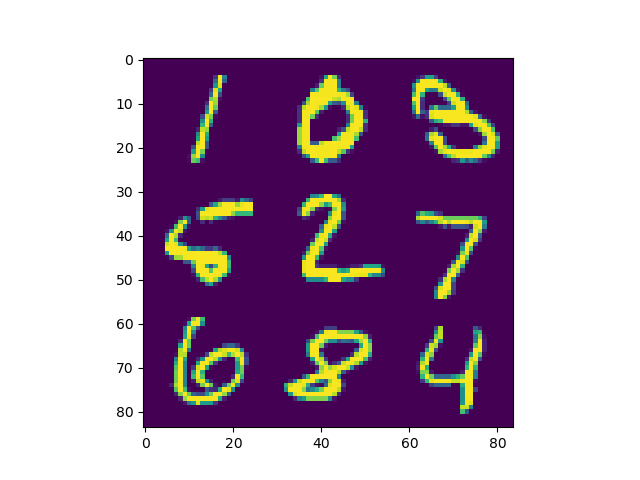

In [17]:
fig, axs = subplots(1)
axs.imshow(input_imgs[0])

# Get Filter

In [18]:
def GetFilter(imgs, targets, number):
    numbers = imgs[np.where(targets==number)[0]]
    
    numbers_mean = np.mean(numbers, axis=0)
    
    numbers_mean_casted = np.zeros((3*28, 3*28))
    
    numbers_mean_casted[28:2*28, 28:2*28] = numbers_mean
    
    filter = np.fft.fft2(numbers_mean_casted)
    filter = np.fft.fftshift(filter)
    
    return filter, numbers_mean_casted

filter, numbers_mean = GetFilter(imgs, targets, target_number)

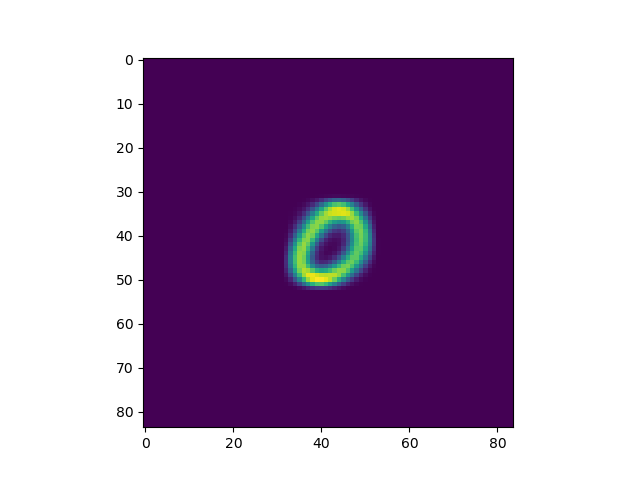

In [19]:
fig, axs = subplots(1)
axs.imshow(numbers_mean)

# Fourier Transforms

In [20]:
filter = np.fft.fft2(numbers_mean)
filter = np.fft.fftshift(filter)

In [21]:
input_fft = np.fft.fft2(input_imgs, axes=(1,2))
input_fft = np.fft.fftshift(input_fft)

In [22]:
filtered = np.zeros(input_fft.shape, dtype=np.complex64)
for _i in range(input_fft.shape[0]):
    filtered[_i] = filter * input_fft[_i]
    
E = np.fft.ifft2(filtered, axes=(1,2))
E = np.fft.fftshift(E)

array([[0., 1., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

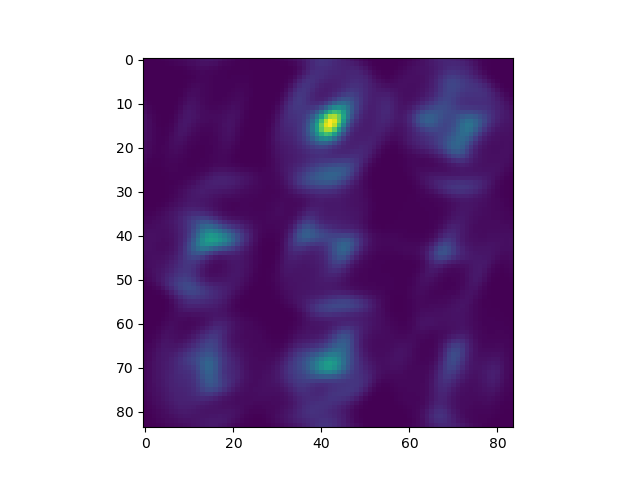

In [23]:
I = np.abs(E)**2

fig, axs = subplots(1)
axs.imshow(np.abs(I[0]))

labels[0]


# Classification

In [24]:
y_pred = np.zeros((filtered.shape[0], 3,3))
for _n in range(filtered.shape[0]):
    for _i in range(3):
        for _j in range(3):
            y_pred[_n, _i, _j] = np.sum(I[_n, _i*28:(_i+1)*28, _j*28:(_j+1)*28], axis=(0,1))
            
    pred = np.zeros((3,3))
    pred[np.where(y_pred[_n]==np.max(y_pred[_n]))] = 1
    
    y_pred[_n] = pred        
    

In [25]:
accuracy = 100*len(np.where(labels==y_pred)[0])/(9*len(labels))

In [26]:
print(100*len(np.where(labels==y_pred)[0])/(9*len(labels)))

84.32984554060788


In [27]:
N = 10

accuracy = np.zeros(N)
for trial in range(N):
    indices = np.arange(number_imgs.shape[1])
    np.random.shuffle(indices)

    number_imgs = number_imgs[:, indices, :, :]
    
    input_imgs = np.zeros((number_imgs.shape[1], 3*28, 3*28))
    labels = np.zeros((number_imgs.shape[1], 3, 3))
    for _i in range(number_imgs.shape[1]):
        input_imgs[_i, :, :], labels[_i, :, :] = PlotImg(number_imgs[:, _i, :, :], target_number)
        
    input_fft = np.fft.fft2(input_imgs, axes=(1,2))
    input_fft = np.fft.fftshift(input_fft)
    
    filtered = np.zeros(input_fft.shape, dtype=np.complex64)
    for _i in range(input_fft.shape[0]):
        filtered[_i] = filter * input_fft[_i]
        
    E = np.fft.ifft2(filtered, axes=(1,2))
    E = np.fft.fftshift(E)
    
    I = np.abs(E)**2
        
    y_pred = np.zeros((filtered.shape[0], 3,3))
    for _n in range(filtered.shape[0]):
        for _i in range(3):
            for _j in range(3):
                y_pred[_n, _i, _j] = np.sum(I[_n, _i*28:(_i+1)*28, _j*28:(_j+1)*28], axis=(0,1))
                
        pred = np.zeros((3,3))
        pred[np.where(y_pred[_n]==np.max(y_pred[_n]))] = 1
        
        y_pred[_n] = pred
    
    accuracy[trial] = 100*len(np.where(labels==y_pred)[0])/(9*len(labels))   
        

In [40]:
print(f"Mean Accuracy = {accuracy.mean()}; Standard Deviation = {accuracy.std()}")

Mean Accuracy = 84.39212755356252; Standard Deviation = 0.09404377722061186
